In [123]:
import copy
import json
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import warnings
from preprocessing import PreProcessing
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE
from imblearn.combine import SMOTEENN
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
                                               add_ball_data=True, half_period="both")

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
                                               add_ball_data=True, half_period="both")

In [4]:
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1,2,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1,3,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1,4,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1,5,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143626,2,143626,5745.04,0.87421,0.49130,0.24651,0.54960,0.46768,0.45048,0.50410,...,0.06431,0.65367,0.32045,0.35375,0.44823,0.50130,0.27748,0.56585,0.03980,0.79348
143627,2,143627,5745.08,0.87414,0.49134,0.24621,0.54978,0.46737,0.45075,0.50368,...,0.06270,0.65501,0.31898,0.35450,0.44782,0.50194,0.27588,0.56625,0.03749,0.84442
143628,2,143628,5745.12,0.87409,0.49134,0.24593,0.54995,0.46703,0.45103,0.50329,...,0.06111,0.65633,0.31752,0.35531,0.44741,0.50256,0.27428,0.56658,0.03519,0.89537
143629,2,143629,5745.16,0.87405,0.49134,0.24567,0.55018,0.46668,0.45130,0.50289,...,0.05959,0.65767,0.31608,0.35611,0.44701,0.50324,0.27274,0.56694,0.03288,0.94632


In [5]:
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
51,1,51,2.04,0.94791,0.48986,0.64787,0.27031,0.67763,0.42630,0.68143,...,0.43295,0.37750,0.49511,0.02246,0.50216,0.50376,0.49565,0.36179,0.50216,0.50376
52,1,52,2.08,0.94779,0.49005,0.64797,0.27005,0.67765,0.42629,0.68101,...,0.43299,0.37743,0.49508,0.02249,0.50214,0.50371,0.49580,0.36160,0.50040,0.50384
53,1,53,2.12,0.94766,0.49025,0.64805,0.26978,0.67767,0.42637,0.68060,...,0.43305,0.37735,0.49507,0.02242,0.50209,0.50366,0.49587,0.36151,0.49770,0.50397
54,1,54,2.16,0.94756,0.49039,0.64815,0.26943,0.67769,0.42634,0.68020,...,0.43311,0.37727,0.49505,0.02235,0.50203,0.50361,0.49598,0.36131,0.49500,0.50410
55,1,55,2.20,0.94746,0.49049,0.64826,0.26908,0.67770,0.42630,0.67978,...,0.43317,0.37719,0.49505,0.02218,0.50195,0.50356,0.49605,0.36121,0.49230,0.50422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140294,2,140294,5611.76,0.07220,0.42214,0.26780,0.11043,0.21891,0.46781,0.20782,...,0.49772,0.52487,0.27637,0.26292,0.25979,0.62951,0.34514,0.14116,0.40008,-0.01407
140295,2,140295,5611.80,0.07237,0.42203,0.26741,0.10964,0.21913,0.46735,0.20811,...,0.49752,0.52392,0.27627,0.26169,0.25982,0.62926,0.34550,0.14096,0.40246,-0.02028
140296,2,140296,5611.84,0.07254,0.42190,0.26701,0.10887,0.21936,0.46697,0.20841,...,0.49732,0.52299,0.27618,0.26049,0.25988,0.62906,0.34586,0.14079,0.40483,-0.02649
140297,2,140297,5611.88,0.07271,0.42170,0.26664,0.10813,0.21957,0.46649,0.20873,...,0.49711,0.52208,0.27610,0.25931,0.25995,0.62887,0.34623,0.14065,0.40721,-0.03270


## Tracking for individual Players for the First Period

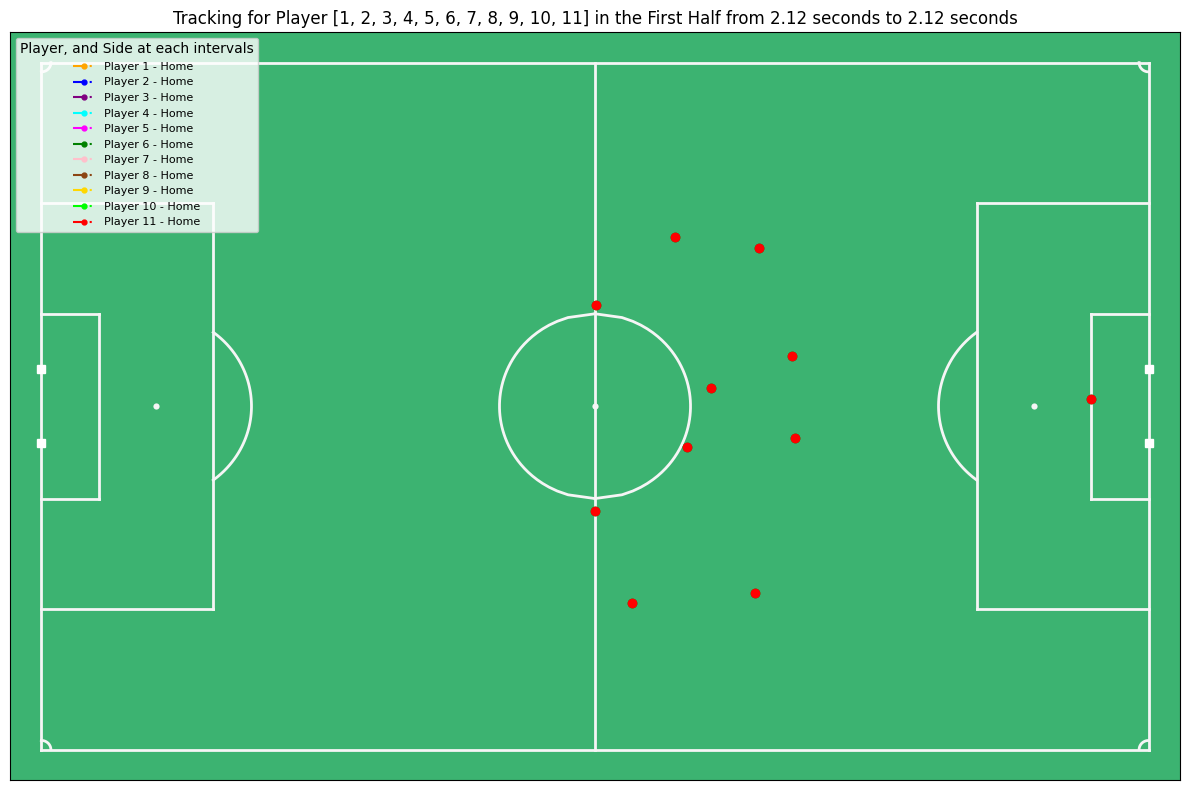

In [6]:
game_2_pre.player_tracking(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [7]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [8]:
vel_acc_game_1_data = game_1_pre.vel_acc(game_1_data)
vel_acc_game_2_data = game_2_pre.vel_acc(game_2_data)

In [9]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,1,3,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.123138,-0.701914
4,1,4,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,0.278458,0.019121,0.478033,0.015201,3.800185e-01,0.029611,0.740275,0.415521,-17.690434
5,1,5,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,1.725677e-01,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143626,2,143626,5745.04,0.87421,0.49130,0.24651,0.54960,0.46768,0.45048,0.50410,...,0.053610,-0.037042,0.042045,0.013916,0.019002,-4.280448e-02,0.042220,-0.013368,1.275058,0.000282
143627,2,143627,5745.08,0.87414,0.49134,0.24621,0.54978,0.46737,0.45075,0.50368,...,0.052367,-0.031080,0.041257,-0.019714,0.019002,7.719519e-14,0.041231,-0.024734,1.274809,-0.006244
143628,2,143628,5745.12,0.87409,0.49134,0.24593,0.54995,0.46703,0.45103,0.50329,...,0.051663,-0.017603,0.041741,0.012105,0.018583,-1.047647e-02,0.040842,-0.009728,1.275047,0.005961
143629,2,143629,5745.16,0.87405,0.49134,0.24567,0.55018,0.46668,0.45130,0.50289,...,0.050658,-0.025120,0.041183,-0.013962,0.019723,2.851242e-02,0.039538,-0.032599,1.275058,0.000282


In [10]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
51,1,51,2.04,0.94791,0.48986,0.64787,0.27031,0.67763,0.42630,0.68143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,1,52,2.08,0.94779,0.49005,0.64797,0.27005,0.67765,0.42629,0.68101,...,0.002016,NaN,0.001061,NaN,0.001346,NaN,0.006052,NaN,0.044045,NaN
53,1,53,2.12,0.94766,0.49025,0.64805,0.26978,0.67767,0.42637,0.68060,...,0.002500,1.211089e-02,0.001768,0.017678,0.001768,0.010537,0.002850,-0.080036,0.067578,5.883191e-01
54,1,54,2.16,0.94756,0.49039,0.64815,0.26943,0.67769,0.42634,0.68020,...,0.002500,2.775558e-14,0.001820,0.001307,0.001953,0.004620,0.005706,0.071398,0.067578,-3.469447e-15
55,1,55,2.20,0.94746,0.49049,0.64826,0.26908,0.67770,0.42630,0.67978,...,0.002500,-2.775558e-14,0.004250,0.060749,0.002358,0.010148,0.003052,-0.066368,0.067567,-2.890418e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140294,2,140294,5611.76,0.07220,0.42214,0.26780,0.11043,0.21891,0.46781,0.20782,...,0.025005,2.447430e-02,0.031394,-0.011880,0.006792,0.018621,0.010262,-0.168491,0.166172,-2.232591e-03
140295,2,140295,5611.80,0.07237,0.42203,0.26741,0.10964,0.21913,0.46735,0.20811,...,0.024271,-1.835974e-02,0.030851,-0.013555,0.006295,-0.012417,0.010296,0.000836,0.166261,2.232591e-03
140296,2,140296,5611.84,0.07254,0.42190,0.26701,0.10887,0.21936,0.46697,0.20841,...,0.023782,-1.222630e-02,0.030084,-0.019180,0.005220,-0.026867,0.009953,-0.008565,0.166172,-2.232591e-03
140297,2,140297,5611.88,0.07271,0.42170,0.26664,0.10813,0.21957,0.46649,0.20873,...,0.023348,-1.084115e-02,0.029568,-0.012913,0.005062,-0.003951,0.009890,-0.001575,0.166261,2.232591e-03


In [11]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]

In [12]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
51,0.94791,0.48986,0.64787,0.27031,0.67763,0.42630,0.68143,0.54622,0.64436,0.77154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,0.94779,0.49005,0.64797,0.27005,0.67765,0.42629,0.68101,0.54602,0.64428,0.77197,...,0.002016,NaN,0.001061,NaN,0.001346,NaN,0.006052,NaN,0.044045,NaN
53,0.94766,0.49025,0.64805,0.26978,0.67767,0.42637,0.68060,0.54582,0.64418,0.77242,...,0.002500,1.211089e-02,0.001768,0.017678,0.001768,0.010537,0.002850,-0.080036,0.067578,5.883191e-01
54,0.94756,0.49039,0.64815,0.26943,0.67769,0.42634,0.68020,0.54562,0.64409,0.77287,...,0.002500,2.775558e-14,0.001820,0.001307,0.001953,0.004620,0.005706,0.071398,0.067578,-3.469447e-15
55,0.94746,0.49049,0.64826,0.26908,0.67770,0.42630,0.67978,0.54545,0.64398,0.77334,...,0.002500,-2.775558e-14,0.004250,0.060749,0.002358,0.010148,0.003052,-0.066368,0.067567,-2.890418e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140294,0.07220,0.42214,0.26780,0.11043,0.21891,0.46781,0.20782,0.27144,0.34694,0.09691,...,0.025005,2.447430e-02,0.031394,-0.011880,0.006792,0.018621,0.010262,-0.168491,0.166172,-2.232591e-03
140295,0.07237,0.42203,0.26741,0.10964,0.21913,0.46735,0.20811,0.27037,0.34738,0.09516,...,0.024271,-1.835974e-02,0.030851,-0.013555,0.006295,-0.012417,0.010296,0.000836,0.166261,2.232591e-03
140296,0.07254,0.42190,0.26701,0.10887,0.21936,0.46697,0.20841,0.26939,0.34779,0.09343,...,0.023782,-1.222630e-02,0.030084,-0.019180,0.005220,-0.026867,0.009953,-0.008565,0.166172,-2.232591e-03
140297,0.07271,0.42170,0.26664,0.10813,0.21957,0.46649,0.20873,0.26844,0.34821,0.09173,...,0.023348,-1.084115e-02,0.029568,-0.012913,0.005062,-0.003951,0.009890,-0.001575,0.166261,2.232591e-03


In [13]:
# game_1_players, game_1_vel_acc = game_1_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_1_ply_tra.loc[:,"P_1_velocity":]
# game_2_players, game_2_vel_acc = game_2_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_2_ply_tra.loc[:,"P_1_velocity":]

In [16]:
game_1_player_data = game_1_pre.get_frames(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2]).round(3).fillna(0)
game_2_player_data = game_2_pre.get_frames(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2]).round(3).fillna(0)

In [17]:
game_2_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
51,0.948,0.490,0.000,0.000,0.648,0.270,0.000,0.000,0.678,0.426,...,0.000,0.000,0.496,0.362,0.000,0.000,0.502,0.504,0.000,0.000
52,0.948,0.490,0.006,0.000,0.648,0.270,0.007,0.000,0.678,0.426,...,0.001,0.000,0.496,0.362,0.006,0.000,0.500,0.504,0.044,0.000
53,0.948,0.490,0.006,0.009,0.648,0.270,0.007,0.002,0.678,0.426,...,0.002,0.011,0.496,0.362,0.003,-0.080,0.498,0.504,0.068,0.588
54,0.948,0.490,0.004,-0.042,0.648,0.269,0.009,0.052,0.678,0.426,...,0.002,0.005,0.496,0.361,0.006,0.071,0.495,0.504,0.068,-0.000
55,0.947,0.490,0.004,-0.019,0.648,0.269,0.009,0.002,0.678,0.426,...,0.002,0.010,0.496,0.361,0.003,-0.066,0.492,0.504,0.068,-0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140294,0.072,0.422,0.005,-0.012,0.268,0.110,0.025,-0.014,0.219,0.468,...,0.007,0.019,0.345,0.141,0.010,-0.168,0.400,-0.014,0.166,-0.002
140295,0.072,0.422,0.005,0.000,0.267,0.110,0.022,-0.076,0.219,0.467,...,0.006,-0.012,0.346,0.141,0.010,0.001,0.402,-0.020,0.166,0.002
140296,0.073,0.422,0.005,0.007,0.267,0.109,0.022,-0.008,0.219,0.467,...,0.005,-0.027,0.346,0.141,0.010,-0.009,0.405,-0.026,0.166,-0.002
140297,0.073,0.422,0.007,0.030,0.267,0.108,0.021,-0.025,0.220,0.466,...,0.005,-0.004,0.346,0.141,0.010,-0.002,0.407,-0.033,0.166,0.002


# Classification

In [ ]:
def change_player_name(data: pd.Series) -> pd.Series:
    result = []
    name = ""
    for i in range(len(data)):
        item = data.iloc[i]
        if len(item) == 8:
            if int(item[-2:]) < 12:
                name = f"Home-P_{item[-2:]}"
            else:
                name = f"Away-P_{item[-2:]}"
        else:
            name = f"Home-P_{item[-1:]}"
            
        result.append(name)

    return pd.Series(data=result, name=data.name)

In [18]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

In [19]:
game_1_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


In [20]:
game_2_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


In [21]:
game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [22]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,RECOVERY,143617,143617,Player16,NaN


In [23]:
def fix_events(event_dataset):
    fixed_event_df = event_dataset.copy()
    
    start_frames = fixed_event_df["Start Frame"].values
    end_frames = fixed_event_df["End Frame"].values
    
    conflict_indices = np.where(start_frames[1:] == end_frames[:-1])[0] + 1
    
    fixed_event_df.loc[fixed_event_df.index[conflict_indices], "Start Frame"] += 1
    
    return fixed_event_df

In [24]:
game_1_event_data = fix_events(game_1_event_data)
game_2_event_data = fix_events(game_2_event_data)

In [25]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,4,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,RECOVERY,143617,143617,Player16,NaN


In [26]:
start_frames = game_1_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_1_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_1_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_1_player_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_1_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_1_event.loc[s:e, "Type"] = e_t

game_1_event = game_1_event.dropna()

In [27]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143626,BALL OUT
143627,BALL OUT
143628,BALL OUT
143629,BALL OUT


In [28]:
start_frames = game_2_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_2_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_2_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_2_player_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_2_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_2_event.loc[s:e, "Type"] = e_t

game_2_event = game_2_event.dropna()

In [29]:
game_2_event

,Type
52,PASS
53,PASS
54,PASS
55,PASS
56,PASS
...,...
140294,BALL OUT
140295,BALL OUT
140296,BALL OUT
140297,BALL OUT


In [172]:
valid_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[valid_indices]
y_1 = game_1_event.loc[valid_indices, "Type"]

In [173]:
valid_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[valid_indices]
y_2 = game_2_event.loc[valid_indices, "Type"]

In [ ]:
# X_1 = game_1_pre.expand_dataset(dataset=X_1, look_back=50)
# X_2 = game_2_pre.expand_dataset(dataset=X_2, look_back=50)

# y_1 = game_1_pre.expand_dataset(dataset=y_1, look_back=50)
# y_2 = game_2_pre.expand_dataset(dataset=y_2, look_back=50)

In [ ]:
X = pd.concat([X_1])#, X_2])
y = y_1#np.concatenate((y_1, y_2))

assert X.shape[0] == y.shape[0]

In [ ]:
np.unique(y, return_counts=True)

In [ ]:
sme = SMOTE(k_neighbors=1)
X, y = sme.fit_resample(X, y)

In [ ]:
X_res.shape

In [ ]:
splits = {"X_train": [], "X_test": [], "y_train": [], "y_test": []}
scaled = {"X_train": [], "X_test": [], "y_train": [], "y_test": []}

for i in range(0, 1):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # splits["X_train"].append(X_train)
    # splits["X_test"].append(X_test)
    # splits["y_train"].append(y_train)
    # splits["y_test"].append(y_test)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_1)
    X_test_scaled = scaler.transform(X_2)
    
    # sme = SMOTE(n_jobs=-2, k_neighbors=1)
    # X_train_res, y_train_res = sme.fit_resample(X_train_scaled, y_train)
    
    scaled["X_train"].append(X_train_scaled)
    scaled["X_test"].append(X_test_scaled)
    scaled["y_train"].append(y_1)
    scaled["y_test"].append(y_2)


In [ ]:
[i.shape for i in splits["X_train"]]

In [ ]:
for k, v in scaled.items():
    for i in v:
        print(k, i.shape)

In [ ]:
warnings.filterwarnings("always")

In [ ]:
def conf_matrix(y_train, y_train_pred, y_test, y_pred, labels, split, model_name=""):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    cm_counts = confusion_matrix(y_test, y_pred, labels=labels)
    cm_normalized = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

    annot = []
    for i in range(len(cm_counts)):
        row_annot = []
        for j in range(len(cm_counts[i])):
            row_annot.append(f"{cm_counts[i, j]} | {cm_normalized[i, j]:.2f}")
        annot.append(row_annot)
    
    sns.heatmap(cm_normalized, 
                annot=annot,
                fmt="", 
                cmap="viridis", 
                xticklabels=labels, 
                yticklabels=labels,
                cbar_kws={"label": "Normalized Frequency"})

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"{model_name.title()} Confusion Matrix Split #{(split+1)}")
    plt.tight_layout()
    plt.show()
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Split #{(split+1)} {model_name} training accuracy: {train_accuracy * 100:0.2f}%")
    print(f"Split #{(split+1)} {model_name} testing accuracy: {test_accuracy * 100:0.2f}%\n")   

In [32]:
scaler = StandardScaler()
X_1 = scaler.fit_transform(X_1)
X_2 = scaler.transform(X_2)

In [33]:
label_encoder = LabelEncoder()
y_1 = label_encoder.fit_transform(y_1)
y_2 = label_encoder.transform(y_2)

In [34]:
np.unique(y_1, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 9809,  2838,   183,     5, 28180,   179,    64,   606],
       dtype=int64))

In [35]:
np.unique(y_2).shape

(8,)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [38]:
input_size = X_1.shape[1]
num_classes = np.unique(y_2).shape[0]
learning_rate = 0.0001
batch_size = 256
num_epochs = 50

In [40]:
X_1_tensor = torch.FloatTensor(X_1)
y_1_tensor = torch.LongTensor(y_1)

X_2_tensor = torch.FloatTensor(X_2)
y_2_tensor = torch.LongTensor(y_2)

# Create dataset
d_1 = TensorDataset(X_1_tensor, y_1_tensor)
d_2 = TensorDataset(X_2_tensor, y_2_tensor)

# Create dataloader with batch_size
train_loader = DataLoader(d_1, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(d_2, batch_size=batch_size, shuffle=False)

In [41]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden_layers=5, starting_size=512):
        super().__init__()
        self.layers = nn.ModuleList()
        prev_size = input_size
        
        sizes = [starting_size // (2**i) for i in range(num_hidden_layers)]

        for size in sizes:
            self.layers.extend([
                nn.Linear(prev_size, size),
                nn.BatchNorm1d(size),
                nn.ReLU()
            ])
            prev_size = size
        
        self.layers.append(nn.Linear(prev_size, num_classes))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [42]:
model = NeuralNetwork(input_size=input_size, num_classes=num_classes, num_hidden_layers=10, starting_size=512).to(device)
model

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=92, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=16, bias=True)
    (16): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=Tru

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_acc = 0
    val_acc = 0
    
    model.train()
    
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(outputs, 1)
        train_acc += (pred == label).sum().item()

    train_acc /= len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        for data, label in validation_loader:
            data, label = data.to(device), label.to(device)
        
            outputs = model(data)
            
            _, pred = torch.max(outputs.data, 1)
            val_acc += (pred == label).sum().item()

    val_acc /= len(validation_loader.dataset)
    
    print(f"Epoch[{epoch + 1}] | training accuracy: {train_acc * 100:0.2f}% | validation accuracy: {val_acc * 100:0.2f}%")

Epoch[1]  | training accuracy: 3.27% | validation accuracy: 6.44%
Epoch[2]  | training accuracy: 5.54% | validation accuracy: 11.99%
Epoch[3]  | training accuracy: 25.21% | validation accuracy: 38.61%
Epoch[4]  | training accuracy: 29.64% | validation accuracy: 42.72%
Epoch[5]  | training accuracy: 29.77% | validation accuracy: 38.96%
Epoch[6]  | training accuracy: 30.09% | validation accuracy: 41.01%
Epoch[7]  | training accuracy: 30.42% | validation accuracy: 43.87%
Epoch[8]  | training accuracy: 30.99% | validation accuracy: 37.13%
Epoch[9]  | training accuracy: 31.52% | validation accuracy: 40.39%
Epoch[10]  | training accuracy: 31.88% | validation accuracy: 41.25%
Epoch[11]  | training accuracy: 33.31% | validation accuracy: 41.30%
Epoch[12]  | training accuracy: 33.93% | validation accuracy: 43.03%
Epoch[13]  | training accuracy: 35.64% | validation accuracy: 42.27%
Epoch[14]  | training accuracy: 36.63% | validation accuracy: 42.71%
Epoch[15]  | training accuracy: 37.93% | valid

In [ ]:
with open("model.pickle", "wb") as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

# New Dataset

In [133]:
new_data = pd.read_csv("data/Sample_Game_3/Sample_Game_3_tracking.txt", sep=r"[;,:]", header=None, engine="python")
new_data.index =  range(1, len(new_data) + 1)

In [134]:
time = np.arange(0.04, (len(new_data) + 1) * 0.04, 0.04).round(2)
new_data.insert(1, "Time [s]", time)

In [135]:
columns = ['Frame', 'Time [s]', 'Home-Player11-x', 'Home-Player11-y', 'Home-Player1-x', 'Home-Player1-y', 'Home-Player2-x', 'Home-Player2-y',
       'Home-Player3-x', 'Home-Player3-y', 'Home-Player4-x', 'Home-Player4-y', 'Home-Player5-x', 'Home-Player5-y', 'Home-Player6-x', 'Home-Player6-y',
       'Home-Player7-x', 'Home-Player7-y', 'Home-Player8-x', 'Home-Player8-y', 'Home-Player9-x', 'Home-Player9-y', 'Home-Player10-x',
       'Home-Player10-y', 'Away-Player25-x', 'Away-Player25-y', 'Away-Player15-x', 'Away-Player15-y', 'Away-Player16-x',
       'Away-Player16-y', 'Away-Player17-x', 'Away-Player17-y', 'Away-Player18-x', 'Away-Player18-y', 'Away-Player19-x',
       'Away-Player19-y', 'Away-Player20-x', 'Away-Player20-y', 'Away-Player21-x', 'Away-Player21-y', 'Away-Player22-x',
       'Away-Player22-y', 'Away-Player23-x', 'Away-Player23-y', 'Away-Player24-x', 'Away-Player24-y', "Ball-x", "Ball-y"]

new_data.columns = columns

In [136]:
new_data #= new_data.iloc[:, :-2]

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,NaN,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,NaN,NaN
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,NaN,NaN
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,NaN,NaN
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,NaN,NaN
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,NaN,NaN
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,NaN,NaN


In [137]:
vel_acc_new_data = game_1_pre.vel_acc(new_data)
vel_acc_new_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,NaN,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,NaN,NaN
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,NaN,NaN
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,NaN,NaN
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,NaN,NaN
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,NaN,NaN
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,NaN,NaN


In [138]:
new_data_ply_tra = vel_acc_new_data.iloc[:, 2:]
new_data_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,NaN,NaN
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,NaN,NaN
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,NaN,NaN
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,NaN,NaN
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,NaN,NaN
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,NaN,NaN
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,NaN,NaN


In [139]:
new_data_player_data = game_1_pre.get_frames(new_data_ply_tra, columns=new_data_ply_tra.columns[0:46:2]).round(3).fillna(0)
new_data_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.847,0.529,0.0,0.0,0.653,0.248,0.000,0.000,0.665,0.466,...,0.000,0.000,0.489,0.364,0.000,0.000,0.0,0.0,0.0,0.0
2,0.847,0.529,0.0,0.0,0.652,0.245,0.070,0.000,0.665,0.465,...,0.005,0.000,0.488,0.364,0.008,0.000,0.0,0.0,0.0,0.0
3,0.847,0.529,0.0,0.0,0.652,0.244,0.033,-0.943,0.665,0.465,...,0.011,0.156,0.488,0.364,0.006,-0.050,0.0,0.0,0.0,0.0
4,0.847,0.529,0.0,0.0,0.652,0.243,0.026,-0.167,0.665,0.465,...,0.014,0.086,0.488,0.363,0.024,0.462,0.0,0.0,0.0,0.0
5,0.847,0.529,0.0,0.0,0.651,0.243,0.011,-0.369,0.665,0.465,...,0.012,-0.044,0.488,0.362,0.010,-0.358,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.120,0.518,0.0,0.0,0.478,0.454,0.018,0.206,0.497,0.773,...,0.007,0.062,0.808,0.271,0.017,-0.018,0.0,0.0,0.0,0.0
143758,0.120,0.518,0.0,0.0,0.478,0.455,0.029,0.282,0.497,0.774,...,0.014,0.170,0.807,0.272,0.028,0.276,0.0,0.0,0.0,0.0
143759,0.120,0.518,0.0,0.0,0.477,0.457,0.048,0.486,0.497,0.776,...,0.022,0.199,0.806,0.272,0.036,0.191,0.0,0.0,0.0,0.0
143760,0.120,0.518,0.0,0.0,0.477,0.459,0.062,0.352,0.497,0.776,...,0.037,0.374,0.804,0.273,0.035,-0.020,0.0,0.0,0.0,0.0


In [140]:
with open("data/Sample_Game_3/Sample_Game_3_events.json", "r") as f:
    data = json.load(f)

In [141]:
type_ = np.array([])
start_frame = np.array([])
end_frame = np.array([])

for i in data["data"]:
    t = i["type"]["name"]
    sf = i["start"]["frame"]
    ef = i["end"]["frame"]

    if t != "CARRY":   
        type_ = np.append(type_, t)
        start_frame = np.append(start_frame, sf)
        end_frame = np.append(end_frame, ef)


new_data_event_data = pd.DataFrame({"Type": type_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})

In [142]:
new_data_event_data

,Type,Start Frame,End Frame
0,SET PIECE,361,361
1,PASS,361,377
2,PASS,384,426
3,PASS,465,507
4,PASS,530,580
...,...,...,...
2220,PASS,143190,143265
2221,PASS,143265,143290
2222,PASS,143406,143469
2223,PASS,143469,143532


In [143]:
new_data_event_data = fix_events(new_data_event_data)

In [144]:
start_frames = new_data_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = new_data_event_data["End Frame"].iloc[1:].to_numpy()
event_types = new_data_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = new_data_player_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
new_data_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    new_data_event.loc[s:e, "Type"] = e_t

new_data_event = new_data_event.dropna()

In [145]:
new_data_event = new_data_event[~(new_data_event["Type"] == "CARD")]
new_data_event#.drop()

,Type
362,PASS
363,PASS
364,PASS
365,PASS
366,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [146]:
new_data_event_data[new_data_event_data["Type"] == "SET PIECE"]

,Type,Start Frame,End Frame
0,SET PIECE,361,361
10,SET PIECE,1125,1125
42,SET PIECE,2845,2845
65,SET PIECE,3995,3995
77,SET PIECE,5829,5829
...,...,...,...
2137,SET PIECE,138299,138299
2146,SET PIECE,139058,139058
2151,SET PIECE,139243,139243
2158,SET PIECE,139591,139591


In [147]:
# with open("model.pickle", "rb") as f:
#     loaded_model = pickle.load(f)

In [174]:
valid_indices = new_data_event.index.intersection(new_data_player_data.index)
X_new = new_data_player_data.loc[valid_indices]
y_new = new_data_event.loc[valid_indices, "Type"]

In [175]:
# X_new = game_1_pre.expand_dataset(dataset=X_new, look_back=50)
# y_new = game_1_pre.expand_dataset(dataset=y_new, look_back=50)

In [176]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CHALLENGE', 'FAULT RECEIVED', 'PASS',
        'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([ 9809,  2838,   183,     5, 28180,   179,    64,   606],
       dtype=int64))

In [177]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CHALLENGE', 'FAULT RECEIVED', 'PASS',
        'RECOVERY', 'SET PIECE', 'SHOT'], dtype=object),
 array([ 7470,  2424,   259,     7, 32378,   165,    70,   534],
       dtype=int64))

In [178]:
np.unique(y_new, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CHALLENGE', 'PASS', 'RECOVERY',
        'SET PIECE', 'SHOT'], dtype=object),
 array([10873,  2612,   254, 42961,   201,    89,   393], dtype=int64))

In [179]:
label_encoder = LabelEncoder()
y_1 = label_encoder.fit_transform(y_1)
y_new = label_encoder.transform(y_new)
y_2 = label_encoder.transform(y_2)

In [180]:
# scaler = MinMaxScaler()
# X_1 = scaler.fit_transform(X_1)
# X_2 = scaler.transform(X_2)
# X_new = scaler.transform(X_new)

In [181]:
print(X_1.shape)
print(X_2.shape)
print(X_new.shape)

(41864, 92)
(43307, 92)
(57383, 92)


In [182]:
# TEMP SOLUTIONS
X_1 = X_1[:41850]
y_1 = y_1[:41850]

X_2 = X_2[:43300]
y_2 = y_2[:43300]

X_new = X_new[:57350]
y_new = y_new[:57350]

In [183]:
print(X_1.shape)
print(X_2.shape)
print(X_new.shape)

(41850, 92)
(43300, 92)
(57350, 92)


In [184]:
np.unique(y_new, return_counts=True)

(array([0, 1, 2, 4, 5, 6, 7]),
 array([10872,  2612,   254, 42929,   201,    89,   393], dtype=int64))

In [185]:
assert X_new.shape[0] == y_new.shape[0]

In [186]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [187]:
np.unique(y_1).shape, np.unique(y_2).shape, np.unique(y_new).shape

((8,), (8,), (7,))

In [197]:
assert X_1.shape[1] == X_2.shape[1] == X_new.shape[1]
# assert np.unique(y).shape == np.unique(y_2).shape == np.unique(y_new).shape

input_size = X_1.shape[1]
hidden_size = 256
num_layers = 3
num_classes = np.unique(y_1).shape[0]
sequence_length = 50
learning_rate = 0.001
batch_size = 256
num_epochs = 50

In [198]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        # Convert pandas DataFrame/numpy arrays to PyTorch tensors
        self.features = torch.tensor(features.values if hasattr(features, 'values') else features, 
                                     dtype=torch.float32)
        self.labels = torch.tensor(labels.values if hasattr(labels, 'values') else labels, 
                                   dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Reshape the NumPy array
X_1_reshaped = X_1.values.reshape(-1, sequence_length, input_size)
X_2_reshaped = X_2.values.reshape(-1, sequence_length, input_size)
X_new_reshaped = X_new.values.reshape(-1, sequence_length, input_size)
print(X_1_reshaped.shape)
# Create DataLoaders
training_dataset = CustomDataset(X_1_reshaped, y_1)
validation_dataset = CustomDataset(X_2_reshaped, y_2)
testing_dataset = CustomDataset(X_new_reshaped, y_new)

training_loader = DataLoader(
    dataset=training_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

testing_loader = DataLoader(
    dataset=testing_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

(837, 50, 92)


In [199]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
        self.init_weights()

    def init_weights(self):
        # Initialize LSTM weights
        for name, param in self.lstm.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
       
        nn.init.xavier_uniform_(self.fc.weight)

        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)
                    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        
        return out

In [200]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model

LSTM(
  (lstm): LSTM(92, 256, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=12800, out_features=8, bias=True)
)

In [201]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
acc = {"training_accuracy": [], "validation_accuracy": [], "testing_accuracy": []}

for epoch in range(num_epochs):
    train_acc = 0
    val_acc = 0
    
    model.train()
    
    for data, label in training_loader:
        data, label = data.to(device), label.to(device)
                
        outputs = model(data)
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, pred = torch.max(outputs, 1)
        train_acc += (pred == label).sum().item()

    train_acc /= len(training_loader.dataset)
    acc["training_accuracy"].append(train_acc)

    model.eval()
    with torch.no_grad():
        for data, label in validation_loader:
            data, label = data.to(device), label.to(device)
        
            outputs = model(data)
            
            _, pred = torch.max(outputs.data, 1)
            val_acc += (pred == label).sum().item()

    val_acc /= len(validation_loader.dataset)
    acc["validation_accuracy"].append(val_acc)
    
    print(f"Epoch[{epoch + 1}] | training accuracy: {train_acc * 100:0.2f}% | validation accuracy: {val_acc * 100:0.2f}%")

Epoch[1] | training accuracy: 17.44% | validation accuracy: 72.63%
Epoch[2] | training accuracy: 63.92% | validation accuracy: 72.63%
Epoch[3] | training accuracy: 63.92% | validation accuracy: 72.63%
Epoch[4] | training accuracy: 63.92% | validation accuracy: 72.63%
Epoch[5] | training accuracy: 63.92% | validation accuracy: 72.63%
Epoch[6] | training accuracy: 63.92% | validation accuracy: 72.63%
Epoch[7] | training accuracy: 63.92% | validation accuracy: 74.25%
Epoch[8] | training accuracy: 63.08% | validation accuracy: 73.79%
Epoch[9] | training accuracy: 65.35% | validation accuracy: 72.75%
Epoch[10] | training accuracy: 65.83% | validation accuracy: 72.63%
Epoch[11] | training accuracy: 64.52% | validation accuracy: 72.75%
Epoch[12] | training accuracy: 68.22% | validation accuracy: 73.21%
Epoch[13] | training accuracy: 70.01% | validation accuracy: 72.63%
Epoch[14] | training accuracy: 68.58% | validation accuracy: 73.21%
Epoch[15] | training accuracy: 70.01% | validation accura

In [202]:
test_acc = 0

model.eval()

with torch.no_grad():
    for data, label in testing_loader:
        data, label = data.to(device), label.to(device)
        
        outputs = model(data)
        
        _, pred = torch.max(outputs.data, 1)
        test_acc += (pred == label).sum().item()

    test_acc /= len(testing_loader.dataset)
    # acc["testing_accuracy"].append(val_acc)

print(f"Accuracy on test set: {test_acc * 100:.2f}%")

Accuracy on test set: 71.49%


In [203]:
def plot_accuracy(accuracy):    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(list(range(1, num_epochs + 1)), accuracy["training_accuracy"], marker="o", label="Training Accuracy")
    ax.plot(list(range(1, num_epochs + 1)), accuracy["validation_accuracy"], marker="o", label="Validation Accuracy")
    # ax.plot(list(range(1, num_epochs + 1)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title("Learning curve")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

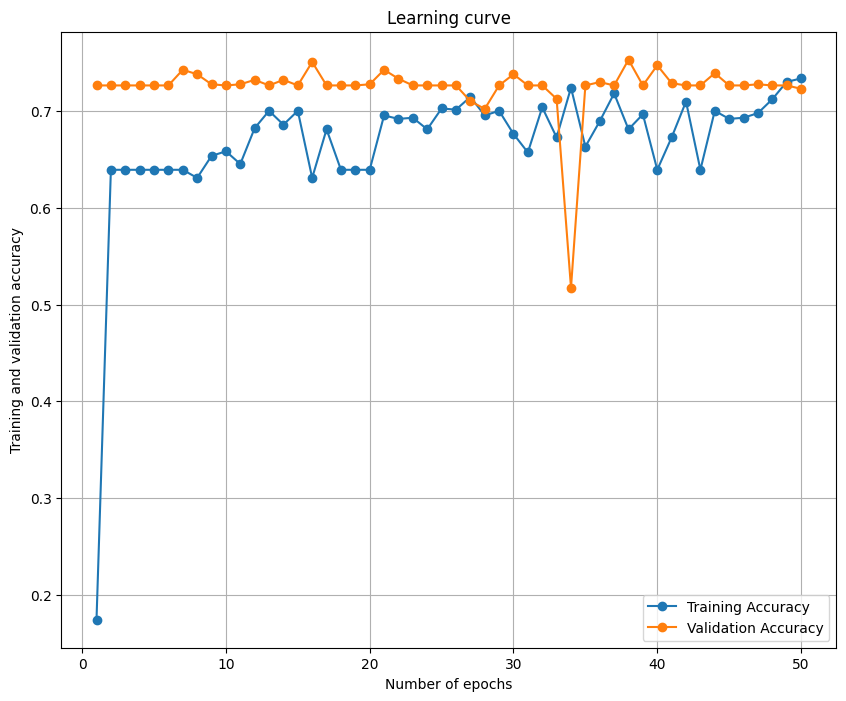

In [204]:
plot_accuracy(acc)